In [41]:
import pandas as pd
from functools import reduce
import numpy as np
import re
import matplotlib as plt
import seaborn as sns
import warnings
from matplotlib import pyplot as plt

%matplotlib inline

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 4000)

In [22]:
#read in data (these are the syndicator data post Carson's initial pre-processing)
b = pd.read_csv("syndicator_b.csv")
i = pd.read_csv("syndicator_i.csv")
g = pd.read_csv("syndicator_g.csv")

In [23]:
b.head()

,Unnamed: 0,id,totalcost,constcost,hardcost,acqucost,landcost,equity_lif,equity_lis,con_type,sources_n,lien1,lien1type,lien2,lien2type,lien3,lien3type,lien4,lien4type,lien5,lien5type,lien6,lien6type,lien7,lien7type,lien8,lien8type,lien9,lien9type,lien10,lien10type,acqudate,con_stdate,concomdate,stabdate,units_n,units_li,units_ot,zipcode,build_n,sqft,tpop,state,df,yr_pis
0,0,33532,"$32,481,257","$32,481,257","$26,248,298",$-,$-,"$10,363,780",$-,New,6.00,"$8,876,272",Soft,"$1,750,000",Soft,"$2,714,861",Soft,"$2,500,000",Soft,"$5,882,070",Soft,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,2/7/13,9/1/11,12/23/14,11/30/15,75.00,74.00,1.00,02111,1.00,"35,986",Elderly,MA,b,2014
1,1,33663,"$5,333,498","$5,179,631","$3,403,697",$-,"$153,867","$1,565,780",$-,New,3.00,"$1,000,000",Hard,"$2,332,547",Soft,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,10/31/14,11/1/14,9/8/15,10/29/15,24.00,24.00,0.00,04426,1.00,"14,436",Elderly,ME,b,2015
2,2,33709,"$6,849,238","$6,849,238","$4,971,098",$-,$-,"$6,336,867",$-,New,2.00,"$900,000",Hard,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,5/1/12,9/21/12,7/29/13,7/30/15,44.00,44.00,0.00,73134,23.00,"41,770",Elderly,OK,b,2013
3,3,33768,"$7,183,151","$6,626,903","$6,270,653",$-,"$556,248","$5,572,243",$-,New,3.00,"$600,000",Hard,"$1,895,224",Soft,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,3/21/14,2/20/14,6/11/15,10/20/15,72.00,72.00,0.00,27896,9.00,"61,308",Family,NC,b,2015
4,4,34008,"$5,957,537","$5,161,743","$5,161,743",$-,"$795,794","$4,030,489",$-,New,3.00,"$1,695,600",Hard,"$1,816,045",Soft,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,8/1/13,8/6/13,12/23/14,12/11/15,56.00,56.00,0.00,27030,5.00,"58,736",Family,NC,b,2014


#### Syndicator B 

In [5]:
cols = ["totalcost","con_type","units_n","yr_pis"]

def clean_syndicator_cols(df,cols,df_name):
    """
    Grab only cols i need to find avg unit cost, clean numeric cols and convert to ints 
    """
    df = df[cols]
    df[cols] = df[cols].replace({'\$': '', ',': ''}, regex=True)
    df[["totalcost","units_n"]] = df[["totalcost","units_n"]].astype(int)
    df["flag"] = df_name
    return df 

In [6]:
#clean strings and turn strings into ints 
b_units_cost = clean_syndicator_cols(b,cols,"b")
b_units_cost.head()

,totalcost,con_type,units_n,flag
0,32481257,New,75,b
1,5333498,New,24,b
2,6849238,New,44,b
3,7183151,New,72,b
4,5957537,New,56,b


#### Syndicator i 

In [7]:
i_units_cost = clean_syndicator_cols(i,cols,"i")
i_units_cost.head()

,totalcost,con_type,units_n,flag
0,16715361,New,98,i
1,8541173,Rehab-Around,100,i
2,22461237,New,80,i
3,73044023,New,136,i
4,23949900,New,65,i


#### Syndicator G 


In [8]:
g = g.dropna()
g_units_cost = clean_syndicator_cols(g,cols,"g")
g_units_cost.head()

,totalcost,con_type,units_n,flag
0,69809586,New Construction,136,g
1,39190669,Rehab,137,g
2,49178710,New Construction,107,g
3,21037569,New Construction,142,g
4,39964744,New Construction,240,g


### Concat together and clean up difference between new and rehab

In [9]:
unit_cost = pd.concat([b_units_cost,i_units_cost,g_units_cost])

In [10]:
#find average cost per unit 
unit_cost["cost_per_unit"] = unit_cost["totalcost"] / unit_cost["units_n"]

In [11]:
#clearly need to standize con_type 
unit_cost.con_type.value_counts()

 New                151
New                 143
 Rehab              107
New Construction    101
Rehab-Around         71
Rehab                29
Rehab - TIP          19
Gut Rehab            12
 Historic Rehab      11
 New/Rehab            6
Acq/Rehab             2
Adaptive              1
Name: con_type, dtype: int64

In [12]:
#drop when it says both new and rehab as unclear what these are and there are few
#and then standarize to just new and rehab
unit_cost = unit_cost[~unit_cost.con_type.isin([' New/Rehab ',"New/Rehab","Acq/Rehab","New Construction & Rehab - TIP","New Construction & Rehab"])]

In [13]:
def categorize_new(x):
    if "New" in x:
        return "New Construction"
    else:
        return "Rehab"
#label new or rehab 
unit_cost["con_type_clean"] = unit_cost.con_type.apply(lambda x: categorize_new(x))                                                                    

### Filtering dataset to new construction only as the main indicator of 9% vs 4% leaves us with 395 observations 

In [16]:
potential_9_new_construction = unit_cost[unit_cost["con_type_clean"] == "New Construction"]

In [19]:
len(potential_9_new_construction)

395

In [21]:
potential_9_new_construction.head()

,totalcost,con_type,units_n,flag,cost_per_unit,con_type_clean
0,32481257,New,75,b,433083.43,New Construction
1,5333498,New,24,b,222229.08,New Construction
2,6849238,New,44,b,155664.50,New Construction
3,7183151,New,72,b,99765.99,New Construction
4,5957537,New,56,b,106384.59,New Construction


In [ ]:
### number of 

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})


sns.lineplot(x="yr_pis", y="sources_n", data=potential_9_new_construction).set_title('Syndicator New Construction Number of Sources Over Time')
plt.ticklabel_format(style='plain', axis='y')

ValueError: Could not interpret value `yr_pis` for parameter `x`

### Syndicator data where the debt to equity ratio is over 50%, implying a 9% project 

In [30]:
b = b.rename(columns={"equity_lif":"equity_net"})


debt_to_equity = pd.concat([b,i])

In [25]:
def is_nine_percent(x):
    if x > .5:
        return "Likely 9% Project"
    else:
        return "Likely 4% Project"

In [33]:
#turn strings into ints to find equity ratio
cols = ['totalcost', 'equity_net']

# pass them to df.replace(), specifying each char and it's replacement:
debt_to_equity[cols] = debt_to_equity[cols].replace({'\$': '', ',': ''}, regex=True)

In [34]:
debt_to_equity["equity_ratio"] = debt_to_equity["equity_net"].astype(int) / debt_to_equity["totalcost"].astype(int)
debt_to_equity["project_type"] = debt_to_equity.equity_ratio.apply(lambda x: is_nine_percent(x))

In [36]:
debt_to_equity["project_type"].value_counts()

Likely 9% Project    315
Likely 4% Project    187
Name: project_type, dtype: int64

In [ ]:
#there are 315 likely 9% projects  

In [38]:
debt_to_equity = debt_to_equity[debt_to_equity["project_type"]=="Likely 9% Project"]

In [ ]:
### normalize for cost increase over time 

In [39]:
debt_to_equity

,Unnamed: 0,id,totalcost,constcost,hardcost,acqucost,landcost,equity_net,equity_lis,con_type,sources_n,lien1,lien1type,lien2,lien2type,lien3,lien3type,lien4,lien4type,lien5,lien5type,lien6,lien6type,lien7,lien7type,lien8,lien8type,lien9,lien9type,lien10,lien10type,acqudate,con_stdate,concomdate,stabdate,units_n,units_li,units_ot,zipcode,build_n,sqft,tpop,state,df,yr_pis,city,sqft_rent,source1type,source1,source2type,source2,source3type,source3,source4type,source4,source5type,source5,source6type,source6,source7type,source7,source8type,source8,source9type,source9,source10type,source10,source11type,source11,loi_date,closedate,equity_ratio,project_type
2,2,33709,6849238,"$6,849,238","$4,971,098",$-,$-,6336867,$-,New,2.00,"$900,000",Hard,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,5/1/12,9/21/12,7/29/13,7/30/15,44.00,44.00,0.00,73134,23.00,"41,770",Elderly,OK,b,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,0.93,Likely 9% Project
3,3,33768,7183151,"$6,626,903","$6,270,653",$-,"$556,248",5572243,$-,New,3.00,"$600,000",Hard,"$1,895,224",Soft,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,3/21/14,2/20/14,6/11/15,10/20/15,72.00,72.00,0.00,27896,9.00,"61,308",Family,NC,b,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,0.78,Likely 9% Project
4,4,34008,5957537,"$5,161,743","$5,161,743",$-,"$795,794",4030489,$-,New,3.00,"$1,695,600",Hard,"$1,816,045",Soft,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,8/1/13,8/6/13,12/23/14,12/11/15,56.00,56.00,0.00,27030,5.00,"58,736",Family,NC,b,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,0.68,Likely 9% Project
5,5,34280,20987345,"$19,810,345","$14,210,065",$-,"$1,177,000",17411007,$-,Rehab,4.00,"$3,995,000",Hard,"$3,000,000",Soft,"$577,250",Soft,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,7/2/12,7/18/13,8/1/14,5/5/15,84.00,83.00,1.00,07208,4.00,"88,650",Family,NJ,b,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,0.83,Likely 9% Project
6,6,34320,6965402,"$6,240,402","$5,846,473",$-,"$725,000",4859514,$-,New,5.00,"$1,076,819",Hard,"$800,000",Hard,"$650,000",Soft,"$530,108",Soft,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,5/6/14,3/28/14,7/29/15,12/1/15,60.00,60.00,0.00,28412,5.00,"52,308",Family,NC,b,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,0.70,Likely 9% Project
7,7,34364,6686115,"$6,023,804","$4,493,692","$613,085","$49,226",5218228,$-,Rehab,2.00,"$1,825,000",Hard,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,12/18/13,12/18/13,1/12/15,5/7/15,52.00,52.00,0.00,59501,8.00,"44,064",Mixed,MT,b,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,0.78,Likely 9% Project
8,8,34378,2669292,"$1,510,349","$1,136,075","$998,943","$160,000",1567946,$-,Rehab,3.00,"$300,000",Hard,"$1,104,794",Hard,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,1/14/15,8/10/15,3/24/16,12/12/16,32.00,32.00,0.00,23881,4.00,"22,848",Family,VA,b,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,0.59,Likely 9% Project
9,9,34401,16007355,"$13,307,355","$10,711,292",$-,"$2,700,000",10733408,$-,New,3.00,"$1,500,000",Soft,"$1,406,289",Soft,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,6/19/13,6/19/13,10/9/14,4/1/15,54.00,54.00,0.00,22314,10.00,"54,204",Mixed,VA,b,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,0.67,Likely 9% Project
10,10,34505,4101471,"$3,901,471","$2,691,058","$150,000","$50,000",3394844,$-,Rehab,2.00,"$349,000",Soft,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,n/a,NaN,12/21/12,1/15/13,2/

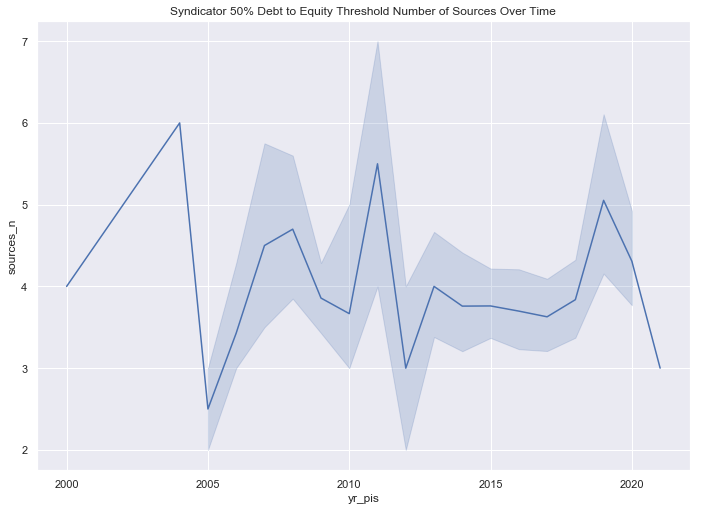

In [42]:
sns.set(rc={'figure.figsize':(11.7,8.27)})


sns.lineplot(x="yr_pis", y="sources_n", data=debt_to_equity).set_title('Syndicator 50% Debt to Equity Threshold Number of Sources Over Time')
plt.ticklabel_format(style='plain', axis='y')

In [46]:
debt_to_equity["Cost Per Unit"] = debt_to_equity["totalcost"].astype(int) / debt_to_equity["units_n"].astype(int)

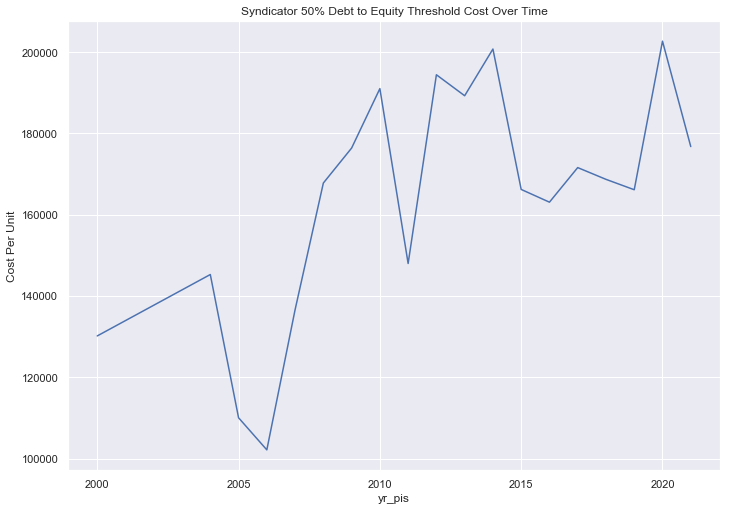

In [47]:
sns.set(rc={'figure.figsize':(11.7,8.27)})


sns.lineplot(x="yr_pis", y="Cost Per Unit",ci=None, data=debt_to_equity).set_title('Syndicator 50% Debt to Equity Threshold Cost Over Time')
plt.ticklabel_format(style='plain', axis='y')